# SYSTEMS ANALYSIS WITH BLOCK DIAGRAMS

# Preliminaries

In [1]:
try:
    import controlSBML as ctl
except:
    !pip -q install controlSBML
    import controlSBML as ctl
import control
from controlSBML.util import makeSimulationTimes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import tellurium as te
print("controlSBML version: " + ctl.__version__)

controlSBML version: 0.2.5


# Helpers

In [48]:
def plotSys(sys, X0, is_plot=True):
    t, y = control.input_output_response(sys, times, X0=X0, params=param_dct)
    if y.ndim == 1:
        y = np.reshape(y, (1, len(y)))
    num_output = np.shape(y)[0]
    for idx in range(num_output):
        plt.plot(t, y[idx])
    plt.xlabel("time")
    legends = ["S2", "S3"]
    if num_output > 2:
        legends.insert(0, "S1")
    plt.legend(legends)
    if not is_plot:
        plt.close()
    
# Test
times = [0.1*v for v in range(51)]
sys = control.tf2io(control.TransferFunction([1], [1, 1]))
plotSys(sys, 10, is_plot=False)
print("OK!")

/home/ubuntu/controlSBML/ctl/lib/python3.6/site-packages/control/iosys.py:842: UserWarning:

Parameters passed to LinearIOSystems are ignored.



> <ipython-input-48-059527c31472>(4)plotSys()
      2     t, y = control.input_output_response(sys, times, X0=X0, params=param_dct)
      3     import pdb; pdb.set_trace()
----> 4     if y.ndim == 1:
      5         y = np.reshape(y, (1, len(y)))
      6     num_output = np.shape(y)[0]



ipdb>  c


OK!


# Sequential Pathways

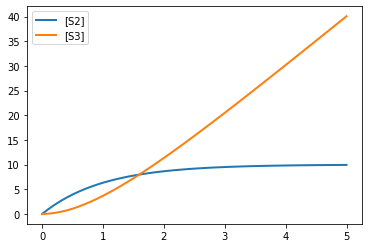

In [2]:
LINEAR_FIXED_MDL= """
S1 -> S2; k1*$S1
S2 -> S3; k2*S2

$S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 1
"""
LINEAR_FIXED_RR = te.loada(LINEAR_FIXED_MDL)
LINEAR_FIXED_RR.plot(LINEAR_FIXED_RR.simulate())

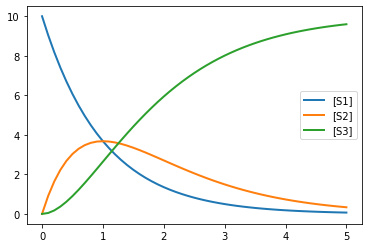

In [3]:
LINEAR_FLOATING_MDL= """
S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 1
"""
LINEAR_FLOATING_RR = te.loada(LINEAR_FLOATING_MDL)
LINEAR_FLOATING_RR.plot(LINEAR_FLOATING_RR.simulate())

# Analysis of *Fixed* Species Input

In [4]:
def updFixed(t, x, u, param_dct):
    """
    Update function for sequential pathway
    
    Parameters
    ----------
    t: float (time)
    x: np.ndarray (state: S2, S3)
    u: float (S1)
    
    Returns
    -------
    dx: np.ndarray (change in state)
    """
    k1 = param_dct["k1"]
    k2 = param_dct["k2"]
    s1 = u
    s2 = x[0]
    S3 = x[1]
    ds2 = k1*s1 - k2*s2
    ds3 = k2*s2
    return ds2, ds3

# Tests
param_dct = {"k1": 1, "k2": 1}
result  = updFixed(0, [0, 0], 10, param_dct)
assert(result[0] == 10)

In [5]:
fixed_sys = control.NonlinearIOSystem(
    updFixed, None, inputs=('u'), outputs=('S2', 'S3'),
    states=('S2', 'S3'), name='fixed_sys')

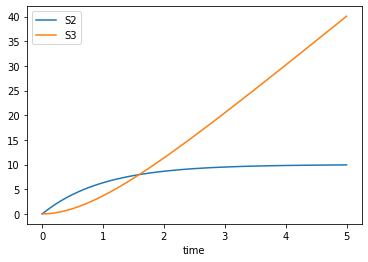

In [21]:
X0 = [0, 0]      
times = [0.1*v for v in range(51)]

# Simulate the system
t, y = control.input_output_response(fixed_sys, times, 10, X0=X0, params=param_dct)
plt.plot(t, y[0])
_ = plt.plot(t, y[1])
plt.xlabel("time")
plt.legend(["S2", "S3"])

In [29]:
tf_1 = control.TransferFunction([1], [1, 1])
tf_inp = control.TransferFunction([1], [1, 0])
print(tf_1, tf_inp)


  1
-----
s + 1
 
1
-
s



In [32]:
times = [0.1*v for v in range(51)]
t, y = control.input_output_response(control.tf2io(tf_1), times, X0=[10])

# Analysis of *Floating* Species Input

In [15]:
def updFloating(t, x, _, param_dct):
    """
    Update function for sequential pathway
    
    Parameters
    ----------
    t: float (time)
    x: np.ndarray (state: S1, S2, S3)
    
    Returns
    -------
    dx: np.ndarray (change in state)
    """
    k1 = param_dct["k1"]
    k2 = param_dct["k2"]
    s1 = x[0]
    s2 = x[1]
    S3 = x[2]
    ds1 = -k1*s1
    ds2 = k1*s1 - k2*s2
    ds3 = k2*s2
    return ds1, ds2, ds3

# Tests
param_dct = {"k1": 1, "k2": 1}
result  = updFloating(0, [10, 0, 0], None, param_dct)
assert(result[0] < 0)

In [16]:
floating_sys = control.NonlinearIOSystem(
    updFloating, None, outputs=('S1', 'S2', 'S3'),
    states=('S1', 'S2', 'S3'), name='floating_sys')

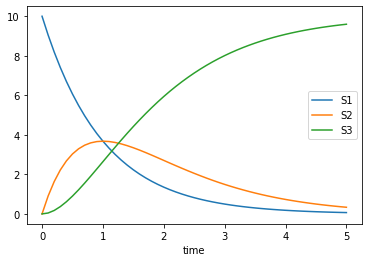

In [22]:
X0 = [10, 0, 0]      
times = [0.1*v for v in range(51)]

# Simulate the system
t, y = control.input_output_response(floating_sys, times, X0=X0, params=param_dct)
for idx in range(np.shape(y)[0]):
    plt.plot(t, y[idx])
plt.xlabel("time")
plt.legend(["S1", "S2", "S3"])